# Hodgkin Huxley model

*Author: Mila Gorecki*

Apply posterior over observation range on a simple Hodgkin Huxley model (taken from sbi tutorials). The goal is to learn model parameters $\bar{g}_{Na}, \bar{g}_{K}$ (sodium and potassium conductance) from clamp recordings. For this example, the traces do not come from real recording, but are simulations. 

#### Import packages and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils import data
import random
import pandas as pd
import seaborn as sns
from functools import partial
from typing import Optional, Tuple, Callable
from torch import optim
from copy import deepcopy

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.neural_nets.flow import build_uncond_maf, build_maf, build_nsf, build_made
from sbi.analysis import pairplot

from examples.HH_helper_functions import syn_current, HHsimulator, calculate_summary_statistics

In [3]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Simulator

Taken from [https://github.com/mackelab/sbi/blob/main/examples/00_HH_simulator.ipynb](https://github.com/mackelab/sbi/blob/main/examples/00_HH_simulator.ipynb)

Define input current as

In [4]:
I, t_on, t_off, dt, t, A_soma = syn_current()

Putting the input current and the HHsimulator together:

In [5]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

### Sample traces
To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:

In [6]:
def generate_traces(params, title=None, file=None):
    num_samples = len(params[:,0])
    sim_samples = np.zeros((num_samples, len(I)))
    sim_spikes = np.zeros(num_samples)
    for i in range(num_samples):
        sim = run_HH_model(params=params[i,:])#['data']
        sim_samples[i,:] = sim['data']
        sim_spikes[i] = calculate_summary_statistics(sim)[0]
    #visualize
    # colors for traces
    col_min = 2
    num_colors = num_samples+col_min
    cm1 = mpl.cm.Blues
    col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

    fig = plt.figure(figsize=(7,5))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    ax = plt.subplot(gs[0])
    plt.axhline(-10, color="r", alpha=0.5) #cut-off for spikes
    for i in range(num_samples):
        plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
    plt.ylabel('voltage (mV)')
    ax.set_xticks([])
    ax.set_yticks([-80, -20, 40])
    if title is not None: 
        plt.title(title)

    ax = plt.subplot(gs[1])
    plt.plot(t,I*A_soma*1e3,'k', lw=2)
    plt.xlabel('time (ms)')
    plt.ylabel('input (nA)')

    ax.set_xticks([0, max(t)/2, max(t)])
    ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

    if file is not None:
        plt.tight_layout()
        plt.savefig('../sbi/figures/' + file+'.pdf')

    plt.show()
    return sim_spikes

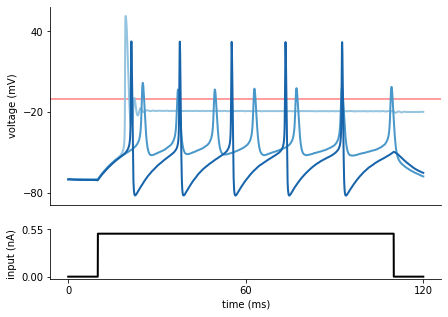

In [7]:
# three sets of (g_Na, g_K)
params = np.array([[50., 1.],[4., 1.5],[20., 15.]])
_ = generate_traces(params)

As can be seen, the voltage traces can be quite diverse for different parameter values.

### Summary Statistics
Often, we are not interested in matching the exact trace, but only in matching certain features thereof. In this example of the Hodgkin-Huxley model, the summary features are:
- the number of spikes, 
- the mean resting potential, 
- the standard deviation of the resting potential, and 
- the first four voltage moments: mean, standard deviation, skewness and kurtosis. 

Using the function `calculate_summary_statistics()`, we obtain these statistics from the output of the Hodgkin Huxley simulator. 

In [8]:
def HHsimulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

def HHsimulation_masked(params, mask=torch.ones(7)):
    """
    Returns selected summary statistics from conductance values in `params`.
    Use mask to indicate which summary statistics to select. 
    For partial evaluation: partial(HHsimulation_masked, mask=...)
    """
    return HHsimulation_wrapper(params)[mask]


## Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [9]:
prior_min = [.5,1e-4]
prior_max = [80.,15.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Inference
Now that we have all the required components, we can run inference with SNPE to identify parameters whose activity matches this trace.

In [10]:
# use spike count only
mask_sc = torch.tensor([True, False, False, False, False, False, False]) 

In [11]:
def inference(simulation, prior, mask=torch.ones(7).bool(), num_sim=3000, load=False):
    simulator, prior = prepare_for_sbi(partial(simulation, mask=mask), prior)
    inference = SNPE(prior=prior)
    if not load: 
        print("Simulate.")
        sim_thetas, sim_xs = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim, num_workers=4)
    else:
        print("Load simulations.")
        # load from simulator with full summary statistics
        sim_xs = torch.load("notebooks/samples/HH_sample_obs_50k.pt")[:, mask]
        sim_thetas = torch.load("notebooks/samples/HH_sample_theta_50k.pt")

    print("Build posterior.")
    inference = inference.append_simulations(sim_thetas, sim_xs)
    density_estimator = inference.train()
    posterior_sbi = inference.build_posterior(density_estimator)

    return sim_xs, sim_thetas, posterior_sbi


# save data?
# torch.save(sim_xs, "mila/samples/HH_sample_obs.pt")
# torch.save(sim_thetas, "mila/samples/HH_sample_theta.pt")

#### Utils

In [12]:
def get_mask(x_range):
    if x_range.type() != "torch.FloatTensor":
            x_range = x_range.float()
    mask = torch.logical_not(
            torch.logical_and(
                x_range[0, :] == float("-inf"),
                x_range[1, :] == float("inf")
            ))
    return mask 


def hist_spikes(obs):
    plt.figure(figsize=(4,3))
    plt.hist(obs[:,0].numpy(), bins=np.arange(max(obs[:,0])+2)-0.5, ec="k", density=True)
    plt.xticks(np.arange(max(obs[:,0])+1))
    plt.title("Spike counts of accepted observations")
    plt.show()

def overview_stats(data, mask=torch.ones(7).bool()):
    return pd.DataFrame(data= torch.vstack([data.mean(dim=0), 
                                            data.std(dim=0), 
                                            data.min(dim=0).values, 
                                            data.max(dim=0).values]).numpy(), 
                        index = ['mean', 'std' , 'min', 'max'], 
                        columns=[i for (i, select) in zip(['spike_count', 'mean_rp',
                                'std_rp', 'mean', 'std', 'skewness', 'kurtosis'], mask) if select]
                        )

### Posterior using all summary statistics 

In [13]:
#sim_xs_full = torch.load("notebooks/samples/HH_sample_obs_50k.pt")

In [14]:
sim_xs_full, sim_thetas_full, posterior_full = inference(HHsimulation_masked, prior, load=True)
#torch.save(sim_xs_full, "notebooks/samples/HH_sample_obs_50k.pt")
#torch.save(sim_thetas_full, "notebooks/samples/HH_sample_theta_50k.pt")
sim_xs_full.shape

Load simulations.
Build posterior.
Neural network successfully converged after 83 epochs.


torch.Size([50000, 7])

Inspect simulated observations

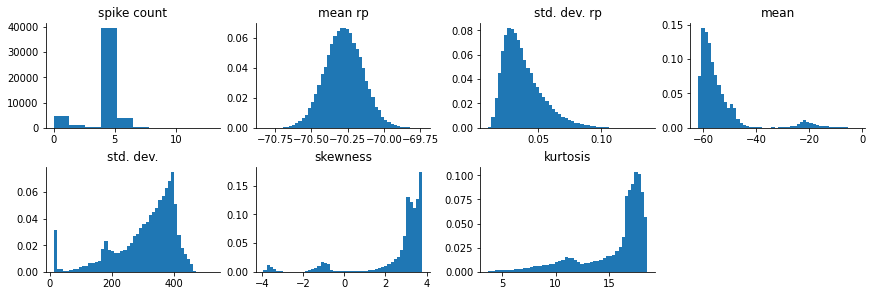

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4), constrained_layout=True)
names = ['spike count', 'mean rp', 'std. dev. rp', 'mean', 'std. dev.', 'skewness', 'kurtosis']
for i in range(sim_xs_full.shape[1]):
    if i==0:
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy())
    else:
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy(), weights=np.zeros_like(sim_xs_full[:,0]) + 1. / sim_xs_full[:,0].shape[0], bins=50)
    axs[i//4,i%4].set_title(names[i])
axs[-1, -1].axis('off')
plt.show()

Correlation between summary statistics

In [19]:
df_sim_xs = pd.DataFrame(sim_xs_full.numpy(), columns=['spike_count', 'mean_rp', 'std_rp', 'mean', 'std', 'skewness', 'kurtosis'])

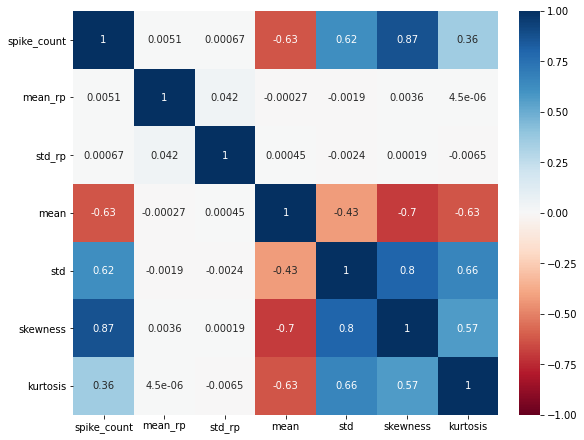

In [20]:
correlation_mat = df_sim_xs.corr()
plt.figure(figsize=(8,6), constrained_layout=True)
sns.heatmap(correlation_mat, annot = True, vmin=-1, vmax=1, cmap="RdBu")
plt.show()

### Posterior Given Single Observation

In [21]:
xo = torch.as_tensor([1.0, -7.0464e+01,  4.4309e-02, -2.1340e+01,  2.2849e+02,-8.1633e-01,  7.2329e+00])
s = posterior_full.sample((10000,), x=xo)

Drawing 10000 posterior samples: 18943it [00:00, 95814.57it/s]                          


Generate some sample traces from the sample parameters:

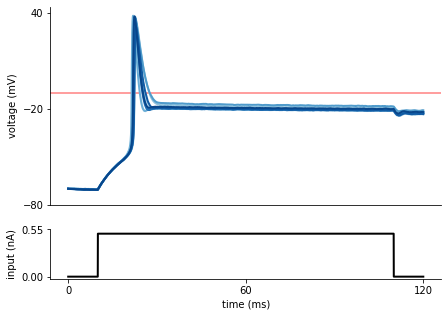

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
generate_traces(s[:10])

Inspect the posterior:

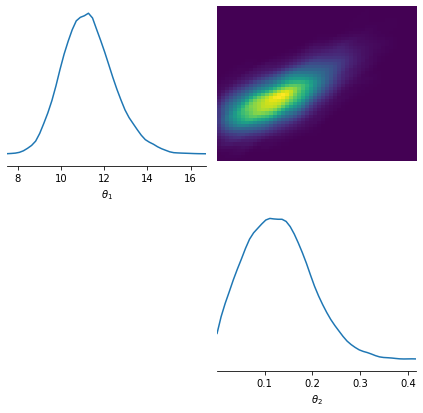

In [23]:
fig, _ = pairplot(s,
                 figsize=(6,6), 
                 #limits=[[.5,80], [1e-4,15.]],
                 #ticks=[[.5,80], [1e-4,15.]],
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

### Posterior Given Range on Spike Count

Specify a range on all dimensions.
When only specifying a range on a subset of dimensions (setting other dimensions to [-inf, inf]), the others will be ignored using a mask as they would be integrated out. Be aware that the posterior is then only specified for the unmasked dimensions, throwing away the others. 

In [24]:
x_range1 = torch.tensor([[0., -np.infty, -np.infty, -np.infty, -np.infty, -np.infty, -np.infty],[3.0, np.infty, np.infty, np.infty, np.infty, np.infty, np.infty]])
mask1 = get_mask(x_range1)

In [25]:
sim_xs1, sim_thetas1, posterior1 = inference(HHsimulation_masked, prior, mask1, load=True)

Load simulations.
Build posterior.
Neural network successfully converged after 63 epochs.


#### No Density Estimation

In [26]:
xs_accepted1, samples1 = posterior1.sample_range(x_range1[:,mask1], sim_xs1, (1000,))
print("Observations:\t\t", xs_accepted1.shape); print("Posterior Samples:\t", samples1.shape)

6009 accepted observations x_i, sampling 1 from each individual posterior p(theta|x_i).
Observations:		 torch.Size([6009, 1])
Posterior Samples:	 torch.Size([6009, 2])


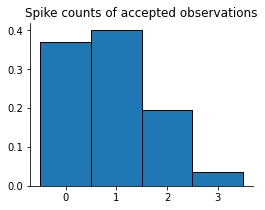

In [27]:
hist_spikes(xs_accepted1)

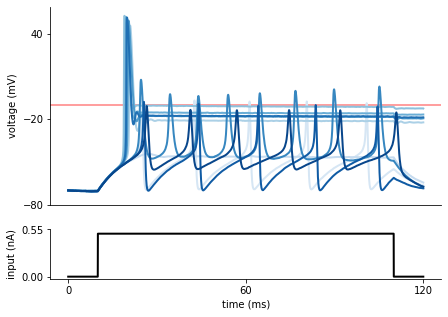

array([5., 0., 1., 1., 1., 1., 8., 1., 2., 0.])

In [28]:
generate_traces(samples1[:10])

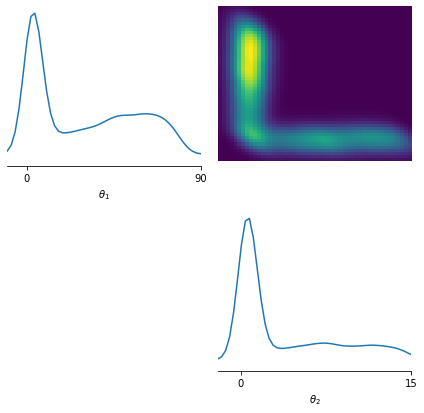

In [29]:
fig, _ = pairplot(samples1,
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

#### With Density Estimation

In [30]:
xs_accepted1_de, samples1_de = posterior1.sample_range(x_range1[:,mask1], sim_xs1, (100,), train_px=True)
print("Observations:\t\t", xs_accepted1_de.shape); print("Posterior Samples:\t", samples1_de.shape)

No context provided, use unconditional MAF.
Train density estimator.
epoch | _val_log_prob | best val_log_prob
    1 |        -2.342 |            -2.342
    2 |        -2.356 |            -2.342
    3 |        -1.882 |            -1.882
    4 |        -1.946 |            -1.882
    5 |         -2.17 |            -1.882
    6 |        -1.815 |            -1.815
    7 |        -1.916 |            -1.815
    8 |        -1.838 |            -1.815
    9 |        -1.864 |            -1.815
   10 |        -1.842 |            -1.815
   11 |        -1.822 |            -1.815
   12 |        -1.832 |            -1.815
   13 |        -1.848 |            -1.815
   14 |        -1.821 |            -1.815
   15 |        -1.809 |            -1.809
   16 |        -1.809 |            -1.809
   17 |        -1.829 |            -1.809
   18 |        -1.804 |            -1.804
   19 |        -1.802 |            -1.802
   20 |        -1.808 |            -1.802
   21 |        -1.846 |            -1.802
   22 |

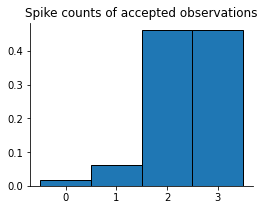

In [31]:
hist_spikes(xs_accepted1_de)

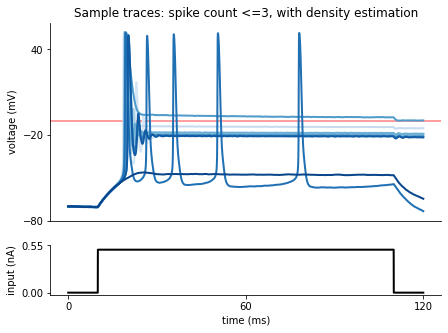

array([3., 1., 2., 1., 1., 2., 1., 5., 2., 0.])

In [32]:
generate_traces(samples1_de[:10], "Sample traces: spike count <=3, with density estimation")

### Posterior Given Range on Spike Count, Mean, Std. Dev.

Say we want to have a range on spike count as well as the mean and the standard deviation. For this example the ranges are chosen after playing around with the simulated observations. In order to find meaningful ranges, a comparision to real experimental data might be interesting to conduct. Also note, that the combnation of ranges on different dimensions has to remain meaningful, they cannot be combined arbitrarily. 

In [33]:
mask2 = torch.tensor([ True, False, False,  True,  True, False, False])
sim_xs2, sim_thetas2, posterior2 = inference(HHsimulation_masked, prior, mask2, load=True)

Load simulations.
Build posterior.
Neural network successfully converged after 74 epochs.


#### Inspect the simulated observations

In [34]:
overview_stats(sim_xs_full)

,spike_count,mean_rp,std_rp,mean,std,skewness,kurtosis
mean,4.603580,-70.277458,0.038049,-53.569771,311.115509,2.627518,15.499107
std,1.445432,0.129249,0.015601,10.440257,98.474838,1.699709,3.162434
min,0.000000,-70.830017,0.010560,-61.960854,11.515804,-3.944681,3.708172
max,13.000000,-69.736969,0.136364,-1.895659,524.650635,3.793479,18.575384


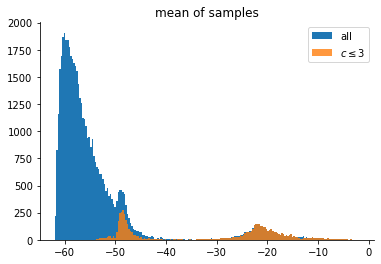

In [35]:
idx = 3
bins = np.linspace(sim_xs_full[:,idx].min().item(), sim_xs_full[:,idx].max().item(), 200)

plt.hist(sim_xs_full[:,idx].numpy(), bins=bins, label='all')
plt.hist(sim_xs_full[sim_xs_full[:,0]<=3][:,idx].numpy(), bins=bins, alpha = 0.8, label=r"$c\leq 3$")
plt.title("mean of samples")
plt.legend()
plt.show()

Fix spike count $c \leq 3$

In [36]:
# fix spike count to <=3
data = sim_xs2[sim_xs2[:,0]<=3]
overview_stats(data, mask2)

,spike_count,mean,std
mean,0.896821,-31.313025,136.245895
std,0.835309,14.330577,91.436508
min,0.000000,-53.882694,11.515804
max,3.000000,-1.895659,372.082214


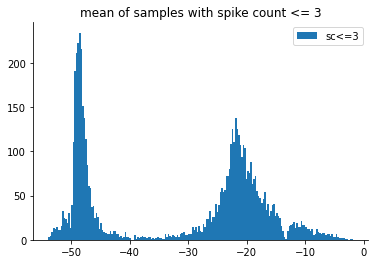

In [37]:
plt.title("mean of samples with spike count <= 3")

idx = 1
bins = np.linspace(data[:,idx].min().item(), data[:,idx].max().item(), 200)

plt.hist(data[:,idx].numpy(), bins=bins, label="sc<=3")
plt.legend()
plt.show()

As the mean looks roughly bimodal, it might be interesting to put a range on the mean around one of the modes. 

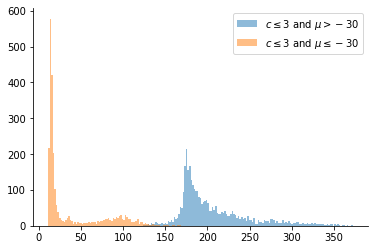

In [38]:
idx=2 #1 mean, 2 std. dev
bins = np.linspace(data[:,idx].min().item(), data[:,idx].max().item(), 200)

plt.hist(data[data[:,1]>-30][:,idx].numpy(), bins=bins, alpha = 0.5, label=r"$c\leq 3$ and $\mu > -30$")
plt.hist(data[data[:,1]<=-30][:,idx].numpy(), bins=bins, alpha = 0.5, label=r"$c\leq 3$ and $\mu \leq -30$")
plt.legend()
plt.show()

When spliting the simulated observation at $\mu = -30$, also the standard deviation of those samples nicely separates with minor overlap. 

#### Range:  $c \in [0,3], \mu \in [-30,0], \sigma \in [150,350]$

In [39]:
x_range2 = torch.tensor([[0, -np.infty, -np.infty, -30.0, 150, -np.infty, -np.infty],
                         [3.0, np.infty, np.infty, 0.0, 350, np.infty, np.infty]])

In [40]:
xs_accepted2, samples2 = posterior2.sample_range(x_range2[:, mask2], sim_xs2, (100,))
print("Observations:\t\t", xs_accepted2.shape); print("Posterior Samples:\t", samples2.shape)

3423 accepted observations x_i, sampling 1 from each individual posterior p(theta|x_i).
Observations:		 torch.Size([3423, 3])
Posterior Samples:	 torch.Size([3423, 2])


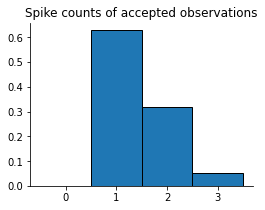

In [41]:
hist_spikes(xs_accepted2)

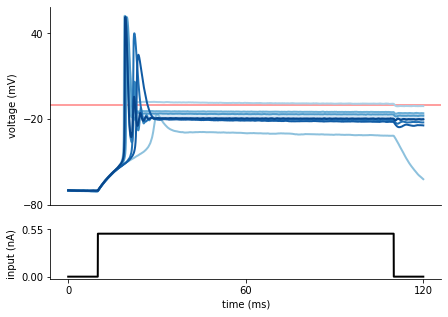

array([1., 1., 2., 0., 1., 1., 2., 1., 1., 2.])

In [42]:
generate_traces(samples2[20:30])

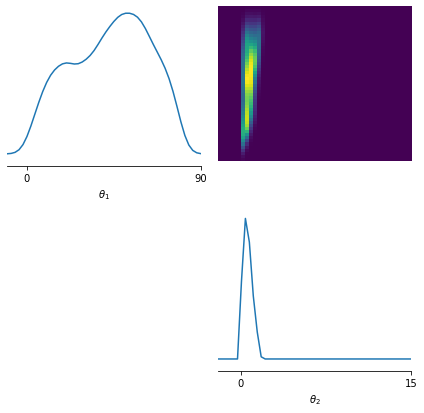

In [43]:
fig, _ = pairplot(samples2, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

#### Range:  $c \in [1,3], \mu \in [-30,0], \sigma \in [150,350]$ with Density Estimation

In [44]:
xs_accepted2_de, samples2_de = posterior2.sample_range(x_range2[:,mask2], sim_xs2, (100,), train_px=True)
print("Observations:\t\t", xs_accepted2_de.shape); print("Posterior Samples:\t", samples2_de.shape)

No context provided, use unconditional MAF.
Train density estimator.
epoch | _val_log_prob | best val_log_prob
   10 |        -6.813 |            -4.592
   20 |        -2.863 |            -2.863
   30 |        -2.485 |            -2.485
   40 |        -26.29 |            -2.485
   50 |        -35.04 |            -2.485
Converged after 50 epochs.
Sample from estimated density.
Sampled 100, accepted 4.
Sampled 100, accepted 3.
Sampled 100, accepted 2.
Sampled 100, accepted 1.
Sampled 100, accepted 4.
Sampled 100, accepted 1.
Sampled 100, accepted 5.
Sampled 100, accepted 3.
Sampled 100, accepted 3.
Sampled 100, accepted 3.
Sampled 100, accepted 4.
Sampled 100, accepted 5.
Sampled 100, accepted 3.
Sampled 100, accepted 4.
Sampled 100, accepted 2.
Sampled 100, accepted 2.
Sampled 100, accepted 2.
Sampled 100, accepted 1.
Sampled 100, accepted 2.
Sampled 100, accepted 9.
Sampled 100, accepted 2.
Sampled 100, accepted 4.
Sampled 100, accepted 2.
Sampled 100, accepted 2.
Sampled 100, accepted

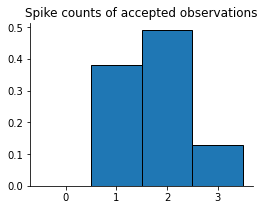

In [45]:
hist_spikes(xs_accepted2_de)

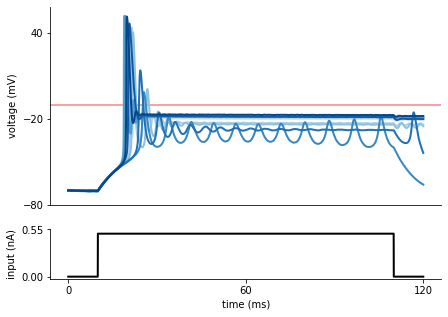

array([2., 2., 2., 2., 2., 2., 1., 1., 1., 1.])

In [46]:
generate_traces(samples2_de[:10])

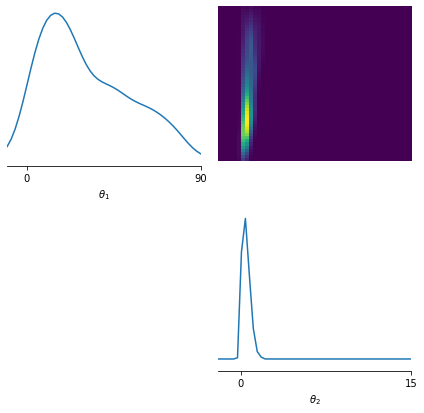

In [47]:
fig, _ = pairplot(samples2_de, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

#### Range:  $c \in [0,3], \mu \in [-70,-30], \sigma \in [0,150]$

2484 accepted observations x_i, sampling 1 from each individual posterior p(theta|x_i).
Observations:		 torch.Size([2484, 3])
Posterior Samples:	 torch.Size([2484, 2])


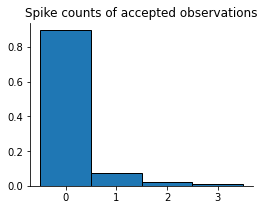

In [48]:
x_range22 = torch.tensor([[0, -np.infty, -np.infty, -70.0, 0, -np.infty, -np.infty],
                         [3.0, np.infty, np.infty, -30.0, 150, np.infty, np.infty]])
                         
xs_accepted22, samples22 = posterior2.sample_range(x_range22[:, mask2], sim_xs2, (100,))
print("Observations:\t\t", xs_accepted22.shape); print("Posterior Samples:\t", samples22.shape)

hist_spikes(xs_accepted22)

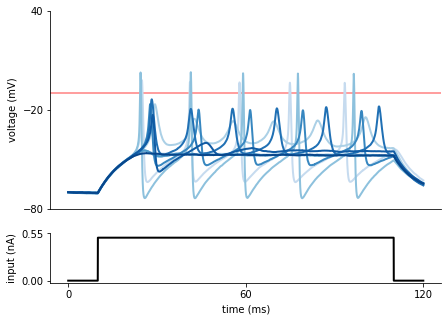

array([0., 5., 0., 5., 0., 0., 0., 0., 0., 0.])

In [49]:
generate_traces(samples22[:10])

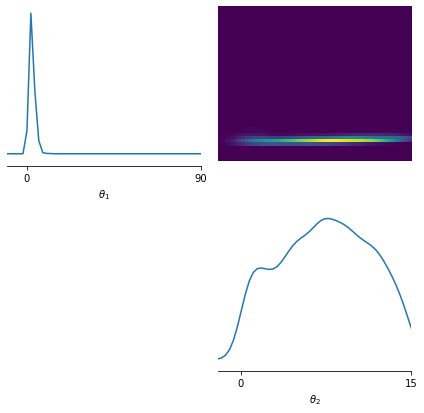

In [50]:
fig, _ = pairplot(samples22, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

### Posterior Given Range with Conditional Flow

Instead of providing a range on all dimensions of the observations, it is often of interest to specify ranges for only a subset of dimensions while keeping others fixed. To do so, we implemented a conditional flow as density estimator.

Let x be an observation, denote as x_range the subset of dimensions for which a observation range is specified and as x_point the dimensions for which a single value is given. Then we can express $p(x) = p(x_{range}|x_{point})p(x_{point})$ and train a conditional flow to estimate $p(x_{range}|x_{point})$.

In [51]:
x_range2

tensor([[  0., -inf, -inf, -30., 150., -inf, -inf],
        [  3.,  inf,  inf,   0., 350.,  inf,  inf]])

In [52]:
mask2 = get_mask(x_range2)
mask2

tensor([ True, False, False,  True,  True, False, False])

In [53]:
range_xs = sim_xs_full[:,mask2]
point_xs = sim_xs_full[:,~mask2]

In [54]:
# get some sample context
points_xs_inrange = point_xs[torch.all(sim_xs_full[:,mask2] >= x_range2[:,mask2][0, :], dim=1) & torch.all(sim_xs_full[:,mask2] <= x_range2[:,mask2][1, :], dim=1)]
print(points_xs_inrange.shape)
c = points_xs_inrange[:1]

torch.Size([3423, 4])


#### Utils

In [55]:
def get_acc_samples(num_samples, flow, x_range):
    mask = get_mask(x_range)
    sample_dim = mask.sum().item()
    x_accepted = torch.empty((0, sample_dim))
    while x_accepted.shape[0] < num_samples:
        with torch.no_grad():
            flow_samples = flow.sample(num_samples=num_samples, context=c).squeeze()
            xs_accepted = flow_samples[
                torch.all(flow_samples >= x_range[:,mask][0, :], dim=1)
                & torch.all(flow_samples <= x_range[:,mask][1, :], dim=1)
            ]
            # print(
            #     f"Sampled {num_samples}, accepted {xs_accepted.shape[0]}."
            # )
            x_accepted = torch.cat((x_accepted, xs_accepted), dim=0)
    return x_accepted

def reassemble(x_accepted, c, mask):
    x_full = torch.empty((x_accepted.shape[0], mask.shape[0]))
    x_full[:, mask] = x_accepted
    x_full[:, ~mask] = c.repeat(x_accepted.shape[0], 1)
    return  x_full
    

#### Conditional flow with NSF

In [57]:
flow_nsf = build_nsf(range_xs, point_xs)
flow_nsf = posterior_full.train_density_estimator(flow_nsf, x=range_xs, context=point_xs)

epoch | _val_log_prob | best val_log_prob
   10 |       -0.6698 |           0.01418
   20 |         1.757 |             1.895
   30 |        0.5007 |             3.385
   40 |         2.483 |             3.385
   50 |         2.736 |             3.773
   60 |         2.586 |             3.832
   70 |         2.867 |             4.555
   80 |         3.236 |             4.661
   90 |         2.924 |             4.817
  100 |         4.428 |             4.886
  110 |         3.467 |             4.886
Converged after 111 epochs.


In [58]:
x_range_acc_nsf = get_acc_samples(100, flow_nsf, x_range2)
x_range_acc_nsf.shape

torch.Size([158, 3])

torch.Size([158, 7])


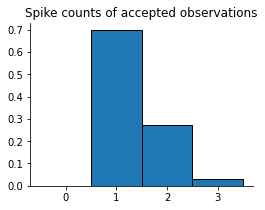

In [59]:
x_acc_nsf = reassemble(x_range_acc_nsf, c, mask2)
print(x_acc_nsf.shape)
hist_spikes(x_acc_nsf)

In [60]:
posterior_samples_nsf = []
for x in x_acc_nsf:
    sample = posterior_full.sample(
            (1,),
            x.unsqueeze(dim=0),
            False,  # show_progress_bars
        )
    posterior_samples_nsf.append(sample)
posterior_samples_nsf = torch.cat(posterior_samples_nsf, dim=0)

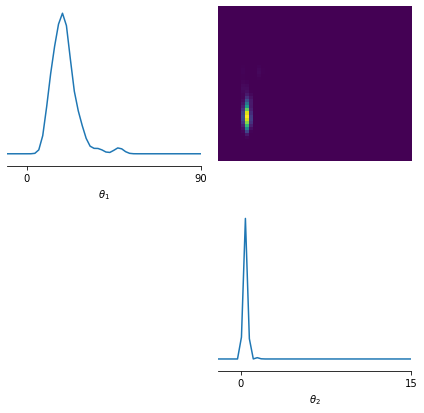

In [63]:
fig, _ = pairplot(posterior_samples_nsf, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

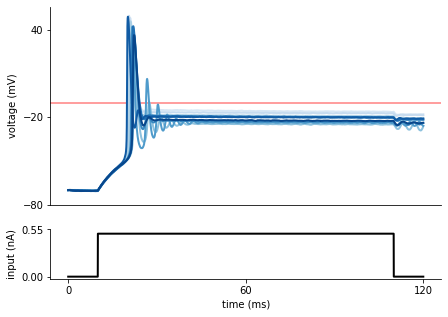

array([1., 1., 1., 2., 1., 2., 1., 1., 1., 1.])

In [64]:
generate_traces(posterior_samples_nsf[:10])

#### Conditional flow with MAF

In [65]:
flow_maf = build_maf(range_xs, point_xs)
flow_maf = posterior_full.train_density_estimator(flow_maf, x=range_xs, context=point_xs, max_num_epochs=120)

epoch | _val_log_prob | best val_log_prob
   10 |       -0.7035 |           -0.6861
   20 |        -6.365 |           0.08839
   30 |        -6.534 |            0.4969
   40 |       -0.2499 |              1.18
   50 |         -14.1 |              1.18
Converged after 52 epochs.


In [66]:
x_range_acc_maf = get_acc_samples(100, flow_maf, x_range2)
x_range_acc_maf.shape

torch.Size([114, 3])

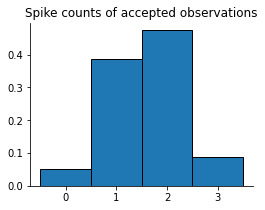

In [67]:
x_acc_maf = reassemble(x_range_acc_maf, c, mask2)
x_acc_maf.shape
hist_spikes(x_acc_maf)

In [68]:
posterior_samples_maf = []
for x in x_acc_maf:
    sample = posterior_full.sample(
            (1,),
            x.unsqueeze(dim=0),
            False,  # show_progress_bars
        )
    posterior_samples_maf.append(sample)
posterior_samples_maf = torch.cat(posterior_samples_maf, dim=0)

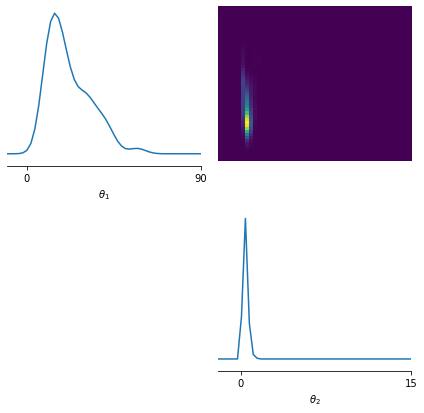

In [69]:
fig, _ = pairplot(posterior_samples_maf, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

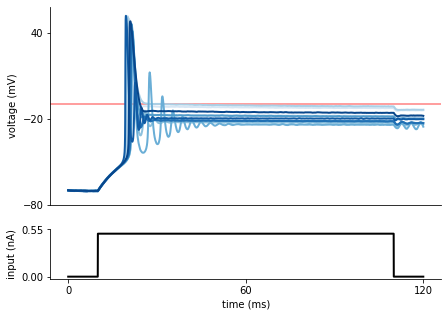

array([1., 1., 2., 1., 3., 1., 1., 1., 2., 1.])

In [70]:
generate_traces(posterior_samples_maf[:10])

#### Conditional flow with MADE
use MADE to approximate $p(x)= p(x_{range}|x_{point})p(x_{point})$

In [71]:
flow_made = build_made(range_xs, point_xs)
flow_made = posterior_full.train_density_estimator(flow_made, x=range_xs, context=point_xs, max_num_epochs=120)

epoch | _val_log_prob | best val_log_prob
   10 |        -3.307 |            -3.307
   20 |        -1.221 |           -0.9638
   30 |        -1.044 |           -0.3147
   40 |       -0.9509 |           -0.1349
   50 |       -0.2096 |            0.0345
   60 |      -0.02268 |            0.1017
   70 |        0.1266 |            0.1478
   80 |         0.266 |             0.266
   90 |        0.1758 |             0.266
  100 |       0.09733 |            0.2827
  110 |       0.07982 |             0.366
  120 |         0.397 |            0.4222


In [72]:
x_range_acc_made = get_acc_samples(100, flow_made, x_range2)
x_range_acc_made.shape

torch.Size([102, 3])

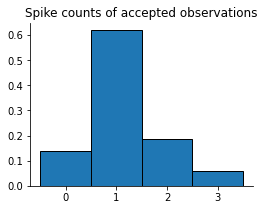

In [73]:
x_acc_made = reassemble(x_range_acc_made, c, mask2)
x_acc_made.shape
hist_spikes(x_acc_made)

In [74]:
posterior_samples_made = []
for x in x_acc_made:
    sample = posterior_full.sample(
            (1,),
            x.unsqueeze(dim=0),
            False,  # show_progress_bars
        )
    posterior_samples_made.append(sample)
posterior_samples_made = torch.cat(posterior_samples_made, dim=0)

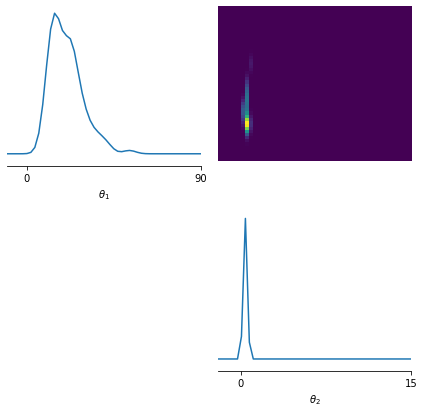

In [75]:
fig, _ = pairplot(posterior_samples_made, 
                 figsize=(6,6), 
                 limits=[[-10,90], [-2,15]],
                 ticks=[[0, 90], [0, 15.]], 
                 upper='kde', diag='kde', 
                 labels=[r'$\theta_1$', r'$\theta_2$'])
fig.tight_layout()

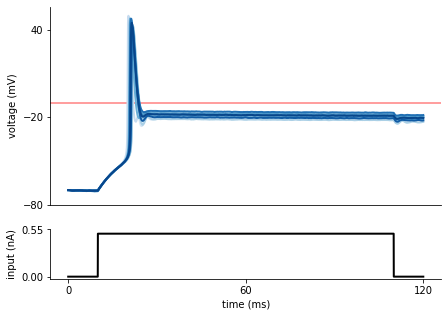

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [76]:
generate_traces(posterior_samples_made[:10])

#### Using sample_range()
If a context is provided and train_px=True, sample_range() trains an conditional NSF to estimate $p(x_{range}|x_{point})$. 

In [77]:
_, post_range_samples = posterior_full.sample_range(x_range2, sim_xs_full, (100,), context=c, max_num_epochs=20,train_px=True)

Context provided, use conditional NSF.
Train density estimator.
epoch | _val_log_prob | best val_log_prob
   10 |        0.6794 |            0.6794
   20 |         1.719 |             1.751
Sample from estimated density.
Sampled 100, accepted 83.
Sampled 100, accepted 78.
161 accepted observations x_i, sampling 1 from each individual posterior p(theta|x_i).


### Posterior Predictives

In [78]:
from tqdm.auto import tqdm

In [79]:
pbar = tqdm(total=posterior_samples_nsf.shape[0])
with pbar: 
    sum_stats = []
    for params in posterior_samples_nsf:
        sum_stats.append(HHsimulation_wrapper(params))
        pbar.update(1)
sum_stats= torch.stack(sum_stats)

100%|██████████| 158/158 [02:55<00:00,  1.11s/it]


In [80]:
x_range2

tensor([[  0., -inf, -inf, -30., 150., -inf, -inf],
        [  3.,  inf,  inf,   0., 350.,  inf,  inf]])

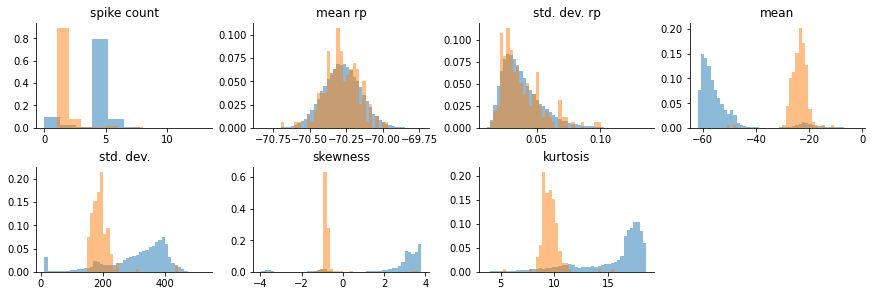

In [82]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4), constrained_layout=True)
names = ['spike count', 'mean rp', 'std. dev. rp', 'mean', 'std. dev.', 'skewness', 'kurtosis']
for i in range(sum_stats.shape[1]):
    if i==0:
        bins = np.arange(sim_xs_full[:,i].min().item(), sim_xs_full[:,i].max().item())
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy(), weights=np.zeros_like(sim_xs_full[:,0]) +1./sim_xs_full.shape[0], alpha=0.5)
        axs[i//4,i%4].hist(sum_stats[:,i].numpy(), bins=bins, weights=np.zeros_like(sum_stats[:,0]) +1./sum_stats.shape[0], alpha=0.5)
    else:
        bins = np.linspace(sim_xs_full[:,i].min().item(), sim_xs_full[:,i].max().item(), 50)
        axs[i//4,i%4].hist(sim_xs_full[:,i].numpy(), weights=np.zeros_like(sim_xs_full[:,0]) + 1. / sim_xs_full[:,0].shape[0], bins=bins, alpha=0.5)
        axs[i//4,i%4].hist(sum_stats[:,i].numpy(), weights=np.zeros_like(sum_stats[:,0]) + 1. / sum_stats.shape[0], bins=bins, alpha=0.5)
    axs[i//4,i%4].set_title(names[i])
axs[-1, -1].axis('off')
plt.show()